# Step 0: Download Data

The following code, download a version of kaggle:omkargurav/face-mask-dataset dataset. we upload a version of it in google drive, the `gdown` command will donwload it and `unzip` command will extract it.

In [1]:
!gdown 1u3j2B9D7pFJmjrW4b0lNoB99RFz1-9v7 -O face-mask-dataset.zip
!unzip face-mask-dataset.zip -d facemask > output.log

Downloading...
From: https://drive.google.com/uc?id=1u3j2B9D7pFJmjrW4b0lNoB99RFz1-9v7
To: /content/face-mask-dataset.zip
100% 171M/171M [00:01<00:00, 104MB/s]


Now, we have our data in `facemask/data` folder, files categorized in two classes female and male.

In [2]:
! ls facemask/data

with_mask  without_mask


Import packages

In [3]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision.transforms.functional import to_tensor
from torch.utils.data import random_split


import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import warnings

# Step 1: Create dataset

The following code, read the data using ImageFolder class, we print the number of images in our dataset and the labels.

In [4]:
data_dir = './facemask/data/'
dataset = ImageFolder(data_dir, transform=ToTensor())
print(len(dataset))
print(dataset.classes)

7553
['with_mask', 'without_mask']


Now, plot an example data from our dataset, `dataset[i][0]` is image and `dataset[i][1]` is label.

Label:  with_mask (0)


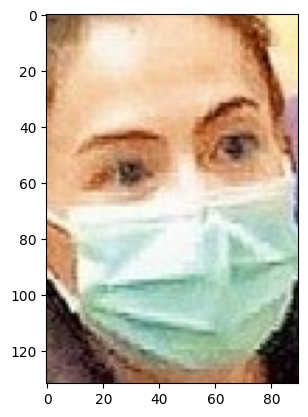

In [5]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_example(*dataset[500])


## Normalize data:

Normalize data to use in the ResNet34 model,
you can read more details about resnet34 model in pytorch from this link: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet34.html

we should resize input to be compatible with our model and normalize it.

In [6]:
import torchvision.transforms as tt
image_size = (224, 224)

stats = {
    'mean': [0.485, 0.456, 0.406],
    'std': [0.229, 0.224, 0.225]
}
dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(image_size),
    tt.ToTensor(),
    tt.Normalize(**stats)
]))

## Split test and train

In [7]:
val_percentage = 0.1
val_size = int(val_percentage * len(dataset))

train_ds, valid_ds = random_split(dataset, [len(dataset) - val_size, val_size])


## DataLoader

In [8]:
batch_size = 256

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


We shuffle training data because while the model is training it see all different example in each mini-batch so that will not learn any unwanted pattern related to the order of data points, however, in validation, it is not necessary. The model should give a valid prediction for any new value in validation set in any order.

`num_workers` argument indicates the number of subprocess that are responsible for loading the data from memory. There is a special kind of memory called pinned memory, content in this section never get swaped out to disk, when we set `pin_memory` to `True`, the tensors of the dataset will get copied into pinned memory.

For example, let see the first batch of train_dl:

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


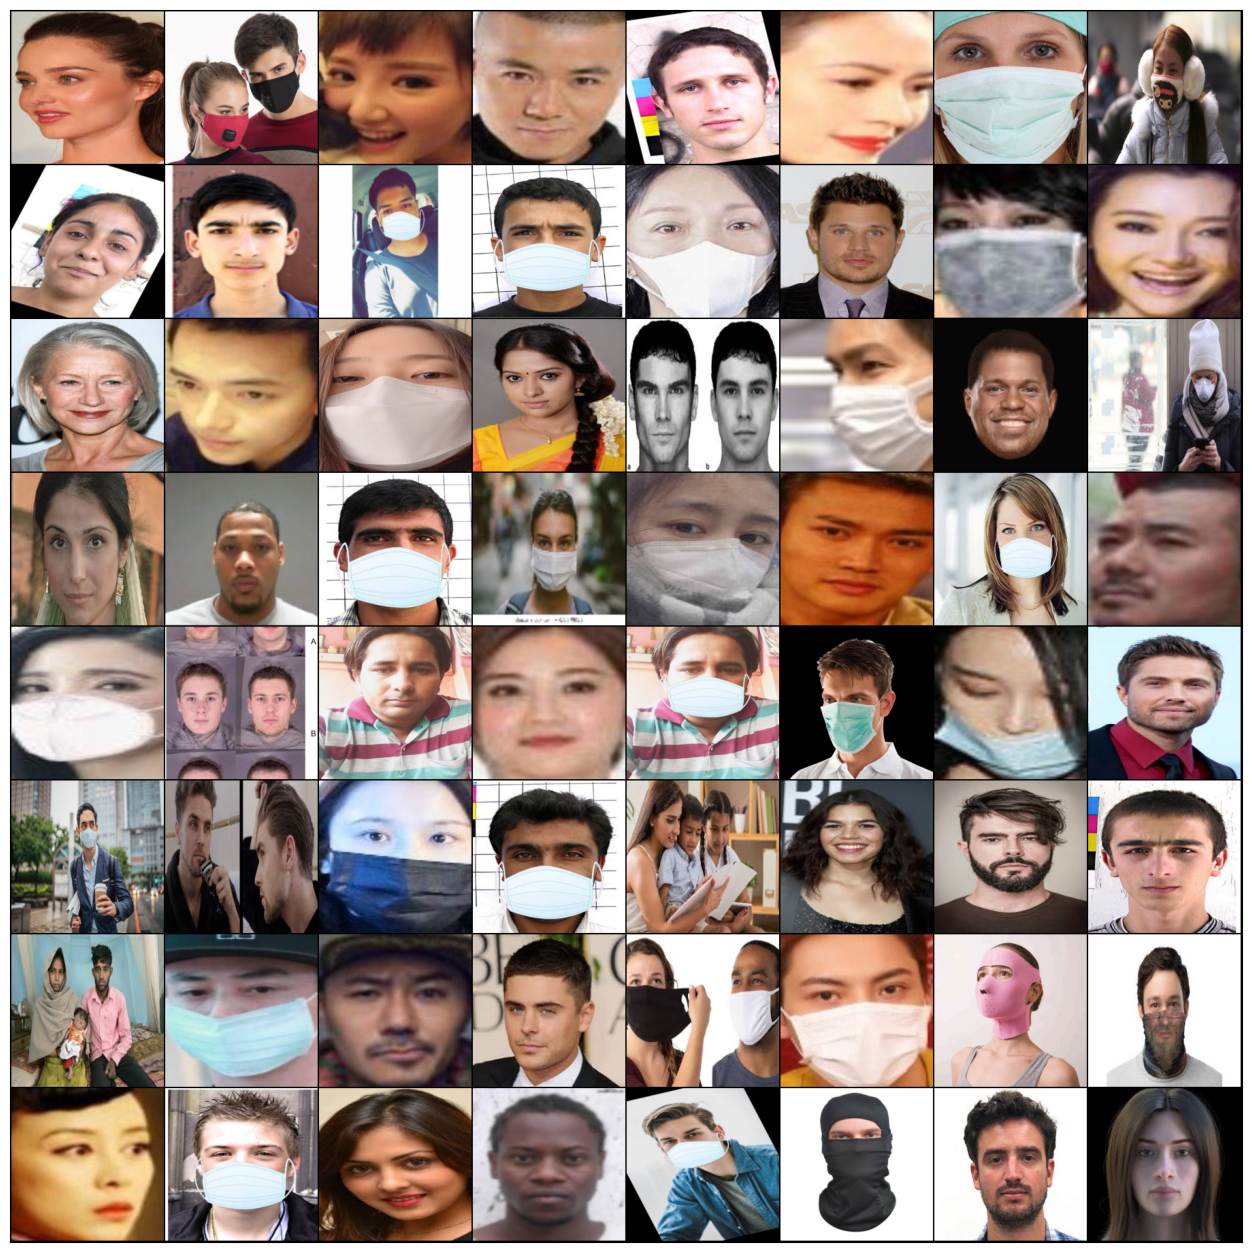

In [9]:
from torchvision.utils import make_grid

def denormalize(images, mean, std):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    mean = torch.tensor(mean).reshape(1, 3, 1, 1)
    std = torch.tensor(std).reshape(1, 3, 1, 1)
    return images * std + mean

def show_first_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], **stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))

        # The break is added to only iterate on the first item
        break

show_first_batch(train_dl)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


# Step 2: Model 1

In [11]:
class MasksModel1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5, 5))
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = nn.Linear(3200, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, X):
        z_1 = self.maxpool1(self.relu1(self.conv1(X)))
        z_2 = self.maxpool2(self.relu2(self.conv2(z_1)))
        z_3 = self.maxpool3(self.relu3(self.conv3(z_2)))
        z_4 = self.maxpool4(self.relu4(self.conv4(z_3)))

        z_4 = torch.flatten(z_4, 1)

        fc1_out = self.fc1(z_4)
        fc2_out = self.fc2(fc1_out)
        fc3_out = self.fc3(fc2_out)

        return nn.Sigmoid()(fc3_out)

## Train and Evaluation

In [12]:
EPOCHS = 5

LOSS_FN = nn.BCELoss()

Train and evaluation helper function, you should complete it:

In [13]:
def train_and_validate(model, optimizer):
    result = []
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch}')
        model.train()
        loss_value = 0
        print('Training')
        for batch_idx, (input_data, input_labels) in enumerate(tqdm((train_dl))):
            input_data = input_data.to(device)
            input_labels = input_labels.to(device)

            y_pred = model(input_data)
            y_true = input_labels.view_as(y_pred).float()

            loss = LOSS_FN(y_pred, y_true)
            loss_value += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch_idx % 5 == 0:
                print(f"Batch #{batch_idx}'s loss: {loss.item():.4f}")

        model.eval()

        train_acc = 0
        train_count = 0

        test_acc = 0
        test_count = 0

        print('Testing')
        with torch.no_grad():
            for input_data, input_labels in tqdm(train_dl):
                input_data = input_data.to(device)
                input_labels = input_labels.to(device)
                y_pred = model(input_data)

                train_predictions = (y_pred >= 0.5).float()

                train_correct = train_predictions == input_labels.view_as(train_predictions)
                train_count += len(input_labels)
                train_acc += train_correct.sum().item()

            for input_data, input_labels in tqdm(valid_dl):
                input_data = input_data.to(device)
                input_labels = input_labels.to(device)
                y_pred = model(input_data)

                test_predictions = (y_pred >= 0.5).float()

                test_correct = test_predictions == input_labels.view_as(test_predictions)
                test_count += len(input_labels)
                test_acc += test_correct.sum().item()

        print(f'Epoch {epoch}: train accuracy {(train_acc/train_count*100):.3f}%, loss: {loss_value:.3f} \
                test accuracy {(test_acc/test_count*100):.3f}%')

        result.append({
            'test_accuracy': (test_acc/test_count*100),
            'train_accuracy': (train_acc/train_count*100),
            'loss_value': loss_value,
        })
    return result

def draw_charts(results):
    plt.figure(figsize=(10, 6))
    plt.plot([result['loss_value'] for result in results])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.xticks(range(EPOCHS))
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot([result['train_accuracy'] for result in results], label='Training Accuracy')
    plt.plot([result['test_accuracy'] for result in results], label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.xticks(range(EPOCHS))
    plt.show()


Now, create an instance from model, initialize an optimizer and train our model!

In [14]:
%%time
warnings.filterwarnings("ignore")

model1 = MasksModel1()
model1 = model1.to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), 0.001)

result = train_and_validate(model1, optimizer1)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.6955
Batch #5's loss: 0.6959
Batch #10's loss: 0.6641
Batch #15's loss: 0.4613
Batch #20's loss: 0.4547
Batch #25's loss: 0.3911
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 85.599%, loss: 15.204                 test accuracy 83.841%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.3347
Batch #5's loss: 0.3143
Batch #10's loss: 0.2902
Batch #15's loss: 0.2892
Batch #20's loss: 0.2727
Batch #25's loss: 0.3398
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 87.717%, loss: 8.870                 test accuracy 85.430%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.2807
Batch #5's loss: 0.2848
Batch #10's loss: 0.2838
Batch #15's loss: 0.2611
Batch #20's loss: 0.3074
Batch #25's loss: 0.2490
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 89.041%, loss: 7.385                 test accuracy 87.285%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.2937
Batch #5's loss: 0.2519
Batch #10's loss: 0.2243
Batch #15's loss: 0.2201
Batch #20's loss: 0.2698
Batch #25's loss: 0.2127
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 90.203%, loss: 6.505                 test accuracy 88.079%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.1532
Batch #5's loss: 0.2811
Batch #10's loss: 0.1965
Batch #15's loss: 0.2254
Batch #20's loss: 0.2459
Batch #25's loss: 0.2022
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 91.792%, loss: 5.754                 test accuracy 89.669%
CPU times: user 22.9 s, sys: 19.7 s, total: 42.6 s
Wall time: 4min 33s


And, draw charts:

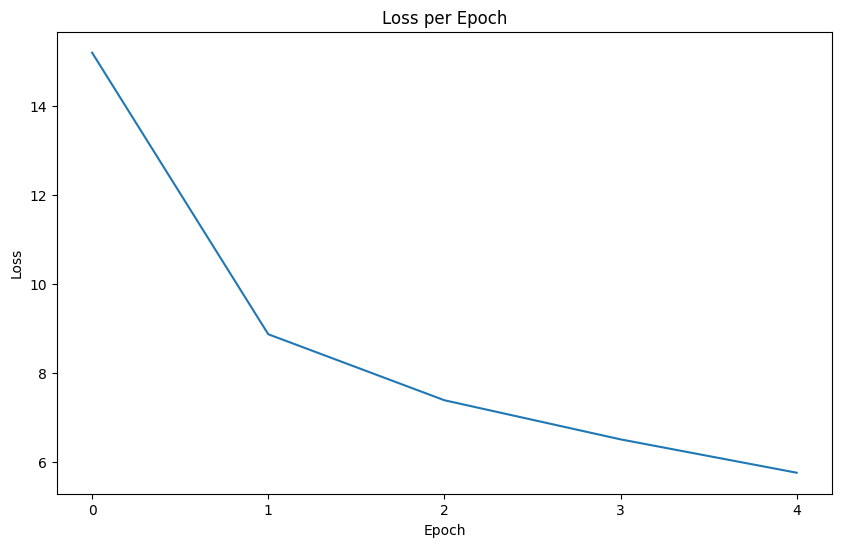

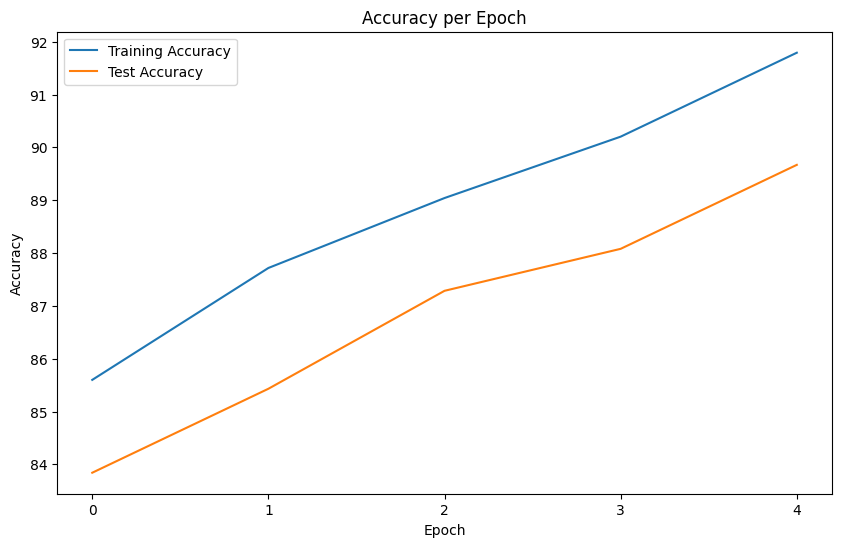

In [15]:
draw_charts(result)

In [16]:
class MasksModel1BN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3))
        self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3))
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5, 5))
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5, 5))
        self.bn4 = nn.BatchNorm2d(32)
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = nn.Linear(3200, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, X):
        z_1 = self.maxpool1(self.relu1(self.bn1(self.conv1(X))))
        z_2 = self.maxpool2(self.relu2(self.bn2(self.conv2(z_1))))
        z_3 = self.maxpool3(self.relu3(self.bn3(self.conv3(z_2))))
        z_4 = self.maxpool4(self.relu4(self.bn4(self.conv4(z_3))))

        z_4 = torch.flatten(z_4, 1)

        fc1_out = self.dropout1(self.fc1(z_4))
        fc2_out = self.fc2(fc1_out)
        fc3_out = self.fc3(fc2_out)

        return nn.Sigmoid()(fc3_out)

In [17]:
%%time
warnings.filterwarnings("ignore")

model1_bn = MasksModel1BN()
model1_bn = model1_bn.to(device)

optimizer1 = torch.optim.Adam(model1_bn.parameters(), 0.001)

result = train_and_validate(model1_bn, optimizer1)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.7086
Batch #5's loss: 0.6475
Batch #10's loss: 0.5324
Batch #15's loss: 0.3206
Batch #20's loss: 0.3089
Batch #25's loss: 0.2920
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 88.055%, loss: 13.026                 test accuracy 85.033%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.2767
Batch #5's loss: 0.2985
Batch #10's loss: 0.2625
Batch #15's loss: 0.2812
Batch #20's loss: 0.2391
Batch #25's loss: 0.2557
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 90.777%, loss: 7.091                 test accuracy 87.682%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.3305
Batch #5's loss: 0.1821
Batch #10's loss: 0.1633
Batch #15's loss: 0.1905
Batch #20's loss: 0.2247
Batch #25's loss: 0.2431
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 91.895%, loss: 5.974                 test accuracy 88.212%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.1789
Batch #5's loss: 0.2128
Batch #15's loss: 0.1889
Batch #20's loss: 0.1650
Batch #25's loss: 0.1510
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 93.057%, loss: 5.547                 test accuracy 90.464%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.1538
Batch #5's loss: 0.3181
Batch #10's loss: 0.1804
Batch #15's loss: 0.2252
Batch #20's loss: 0.1531
Batch #25's loss: 0.1320
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 94.072%, loss: 4.856                 test accuracy 92.185%
CPU times: user 24.8 s, sys: 18.2 s, total: 43 s
Wall time: 4min 40s


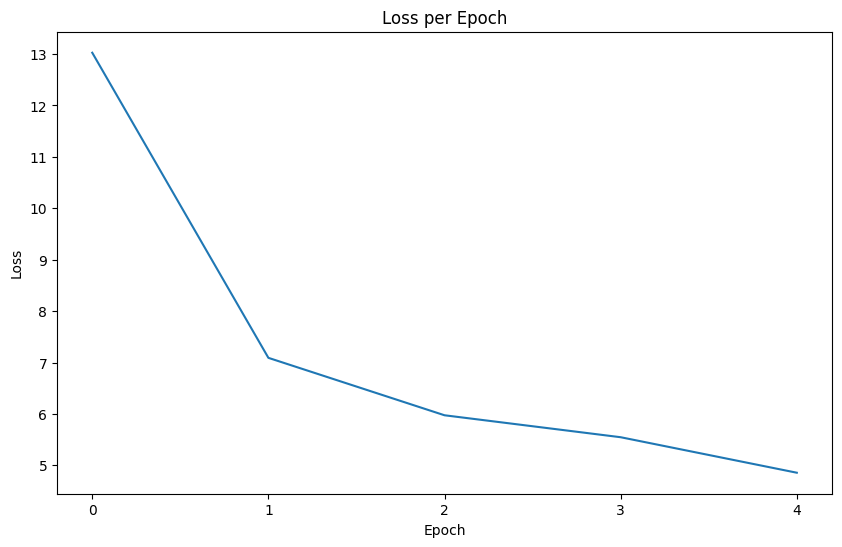

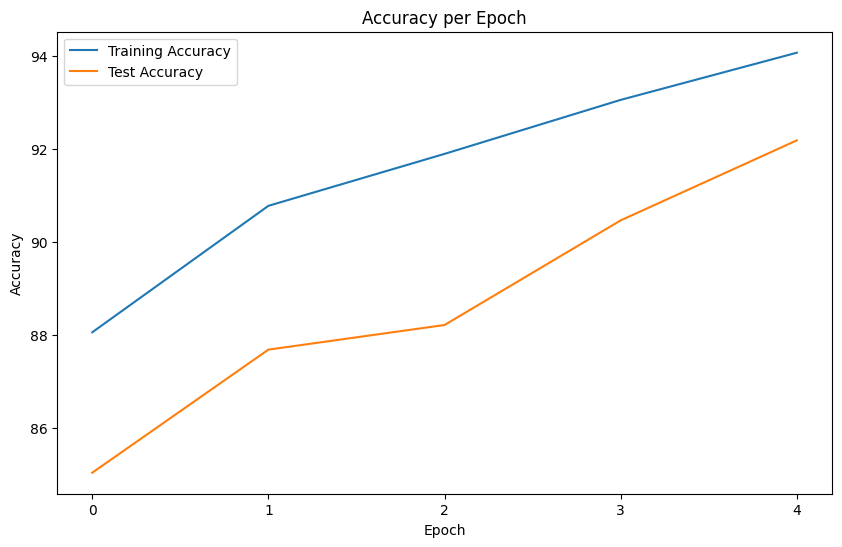

In [18]:
draw_charts(result)

# Step 3: Transfer Learning

Let see the pytorch resnet34 model:

In [19]:
from torchvision import models
models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 76.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

What's the name of last layer of resnet34? Average Pooling, it basically getting average of each feature map that previous convolutional layers computed. It does not have any explicit paramaters so it is an effective computionally cheap layer to aggregate information.

Now, we create a new model which uses resnet34 as a base_model and modify it:

In [20]:
class MasksModelFromResNet(nn.Module):
    def __init__(self, num_classes, pretrained=True, train_all_layers=True):
        super().__init__()

        weights = None
        if pretrained:
           weights = models.resnet34().state_dict()

        self.base_model = models.resnet34(weights=weights)

        if not train_all_layers:
            for param in self.base_model.parameters():
                param.requires_grad = False

        self.base_model.fc = nn.Linear(in_features=512, out_features=1)

    def forward(self, x):
        return nn.Sigmoid()(self.base_model.forward(x))

    def to(self, device):
        new_model = super().to(device)
        new_model.base_model = new_model.base_model.to(device)
        return new_model

## Train without pretrained weights

In [21]:
%%time
warnings.filterwarnings("ignore")

model2 = MasksModelFromResNet(len(dataset.classes), pretrained=False, train_all_layers=True)
model2 = model2.to(device)

optimizer2 = torch.optim.Adam(model2.parameters(), 0.0001)

result = train_and_validate(model2, optimizer2)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.7892
Batch #5's loss: 0.5356
Batch #10's loss: 0.3983
Batch #15's loss: 0.3681
Batch #20's loss: 0.3200
Batch #25's loss: 0.2770
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 84.363%, loss: 11.474                 test accuracy 82.914%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.1983
Batch #5's loss: 0.1948
Batch #10's loss: 0.1766
Batch #15's loss: 0.2346
Batch #20's loss: 0.1802
Batch #25's loss: 0.1160
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 92.660%, loss: 5.272                 test accuracy 88.874%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0833
Batch #5's loss: 0.1014
Batch #10's loss: 0.1203
Batch #15's loss: 0.0898
Batch #20's loss: 0.0775
Batch #25's loss: 0.0653
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 98.485%, loss: 2.588                 test accuracy 94.570%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0439
Batch #5's loss: 0.0359
Batch #10's loss: 0.0450
Batch #15's loss: 0.0275
Batch #20's loss: 0.0527
Batch #25's loss: 0.0306
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 99.073%, loss: 1.121                 test accuracy 93.510%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0133
Batch #5's loss: 0.0235
Batch #10's loss: 0.0250
Batch #15's loss: 0.0155
Batch #20's loss: 0.0114
Batch #25's loss: 0.0240
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 91.439%, loss: 0.645                 test accuracy 86.623%
CPU times: user 2min 2s, sys: 18.4 s, total: 2min 21s
Wall time: 5min 55s


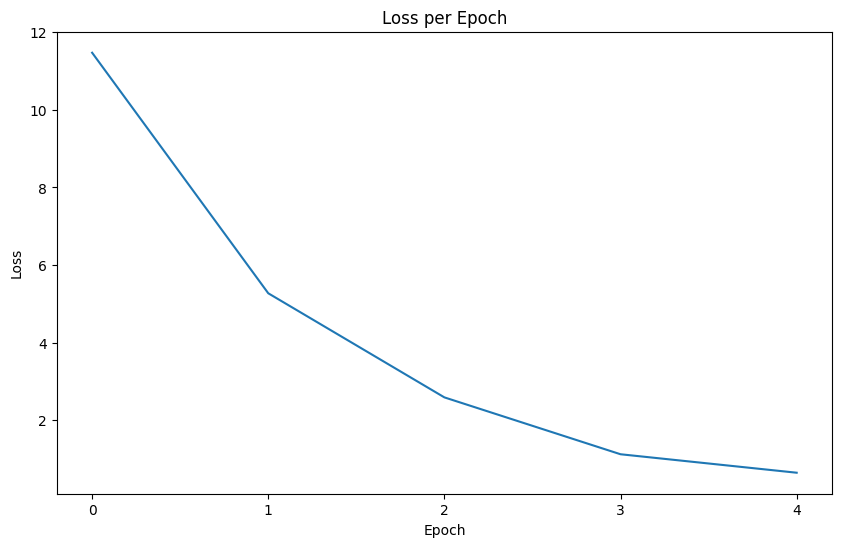

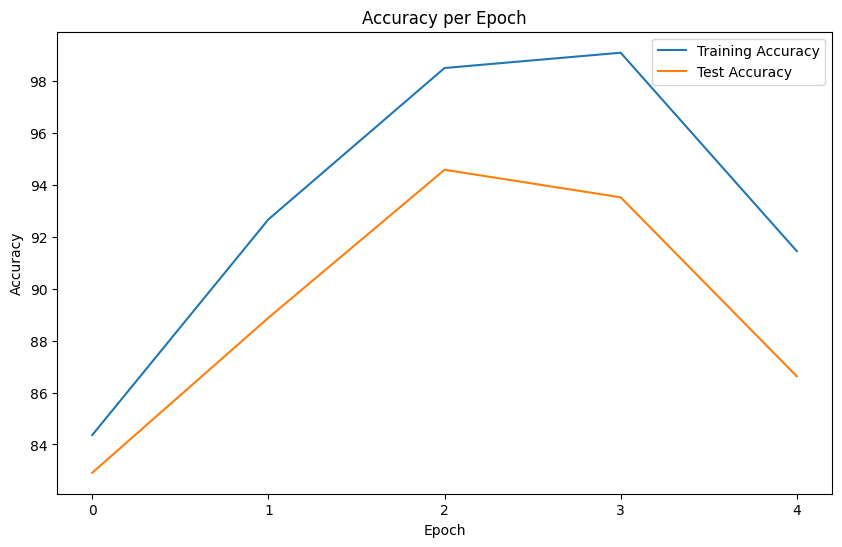

In [22]:
draw_charts(result)

## Training From pretrained model, only change the weights of last layer

In [23]:
%%time
warnings.filterwarnings("ignore")

model3 = MasksModelFromResNet(len(dataset.classes), pretrained=True, train_all_layers=False)
model3 = model3.to(device)

optimizer3 = torch.optim.Adam(model3.parameters(), 0.0001)

result = train_and_validate(model3, optimizer3)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.6841
Batch #5's loss: 0.7026
Batch #10's loss: 0.6565
Batch #15's loss: 0.6651
Batch #20's loss: 0.6146
Batch #25's loss: 0.6151
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 68.594%, loss: 17.686                 test accuracy 68.609%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.5989
Batch #5's loss: 0.6052
Batch #10's loss: 0.5915
Batch #15's loss: 0.5935
Batch #20's loss: 0.5879
Batch #25's loss: 0.5748
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 76.684%, loss: 16.105                 test accuracy 76.821%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.5793
Batch #5's loss: 0.5573
Batch #10's loss: 0.5518
Batch #15's loss: 0.5280
Batch #20's loss: 0.5285
Batch #25's loss: 0.5299
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 82.613%, loss: 14.731                 test accuracy 81.722%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.5055
Batch #5's loss: 0.5167
Batch #10's loss: 0.5142
Batch #15's loss: 0.5016
Batch #20's loss: 0.4894
Batch #25's loss: 0.4839
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 87.099%, loss: 13.574                 test accuracy 85.960%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.4910
Batch #5's loss: 0.4663
Batch #10's loss: 0.4539
Batch #15's loss: 0.4567
Batch #20's loss: 0.4727
Batch #25's loss: 0.4690
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 89.718%, loss: 12.549                 test accuracy 89.139%
CPU times: user 1min 4s, sys: 18.9 s, total: 1min 23s
Wall time: 5min 2s


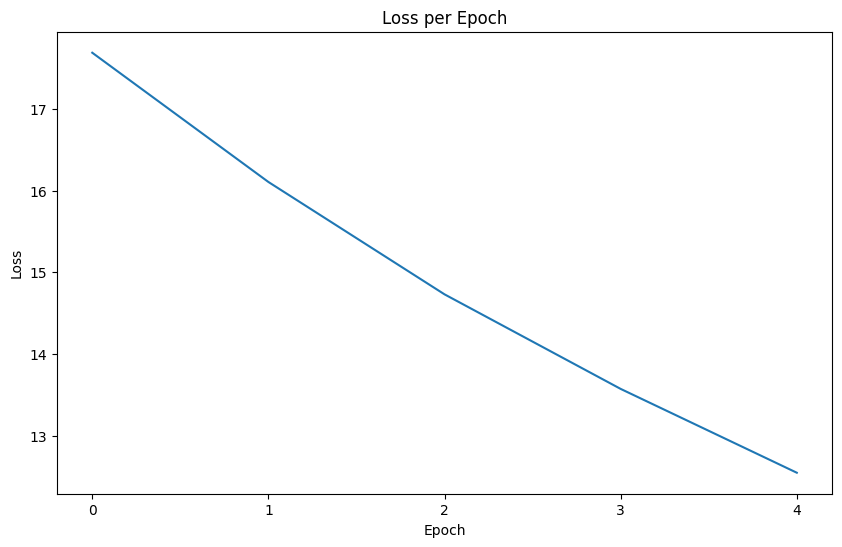

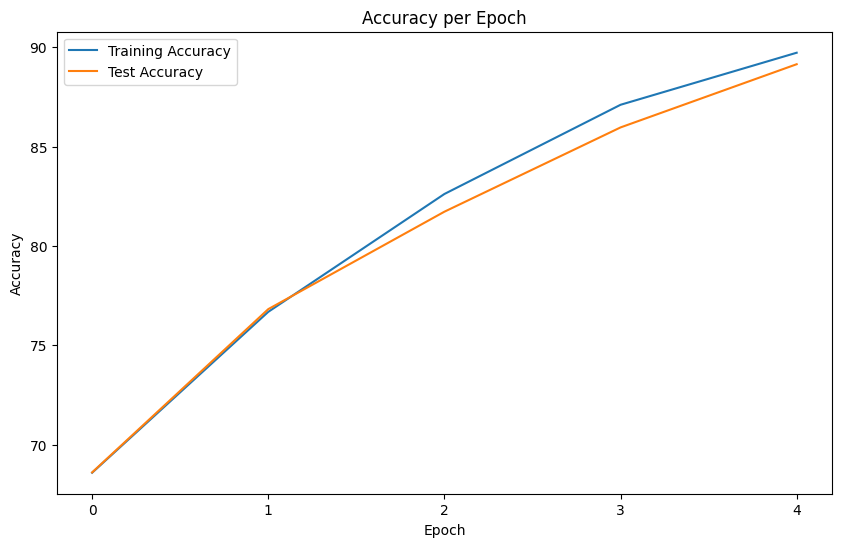

In [24]:
draw_charts(result)

## Training From pretrained model, fine tune all weights

In [25]:
%%time
warnings.filterwarnings("ignore")

model4 = MasksModelFromResNet(len(dataset.classes), pretrained=True, train_all_layers=True)
model4 = model4.to(device)

optimizer4 = torch.optim.Adam(model4.parameters(), 0.0001)

result = train_and_validate(model4, optimizer4)

Epoch 0
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.7319
Batch #5's loss: 0.0547
Batch #10's loss: 0.0154
Batch #15's loss: 0.0048
Batch #20's loss: 0.0351
Batch #25's loss: 0.0091
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0: train accuracy 99.897%, loss: 1.977                 test accuracy 99.338%
Epoch 1
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0011
Batch #5's loss: 0.0014
Batch #10's loss: 0.0007
Batch #15's loss: 0.0005
Batch #20's loss: 0.0006
Batch #25's loss: 0.0049
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: train accuracy 99.985%, loss: 0.072                 test accuracy 99.470%
Epoch 2
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0004
Batch #5's loss: 0.0034
Batch #10's loss: 0.0005
Batch #15's loss: 0.0019
Batch #20's loss: 0.0006
Batch #25's loss: 0.0004
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: train accuracy 100.000%, loss: 0.043                 test accuracy 99.338%
Epoch 3
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0004
Batch #5's loss: 0.0004
Batch #10's loss: 0.0005
Batch #15's loss: 0.0003
Batch #20's loss: 0.0004
Batch #25's loss: 0.0003
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: train accuracy 100.000%, loss: 0.017                 test accuracy 99.338%
Epoch 4
Training


  0%|          | 0/27 [00:00<?, ?it/s]

Batch #0's loss: 0.0004
Batch #5's loss: 0.0004
Batch #10's loss: 0.0003
Batch #20's loss: 0.0002
Batch #25's loss: 0.0002
Testing


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: train accuracy 100.000%, loss: 0.008                 test accuracy 99.338%
CPU times: user 2min 5s, sys: 18.8 s, total: 2min 24s
Wall time: 5min 49s


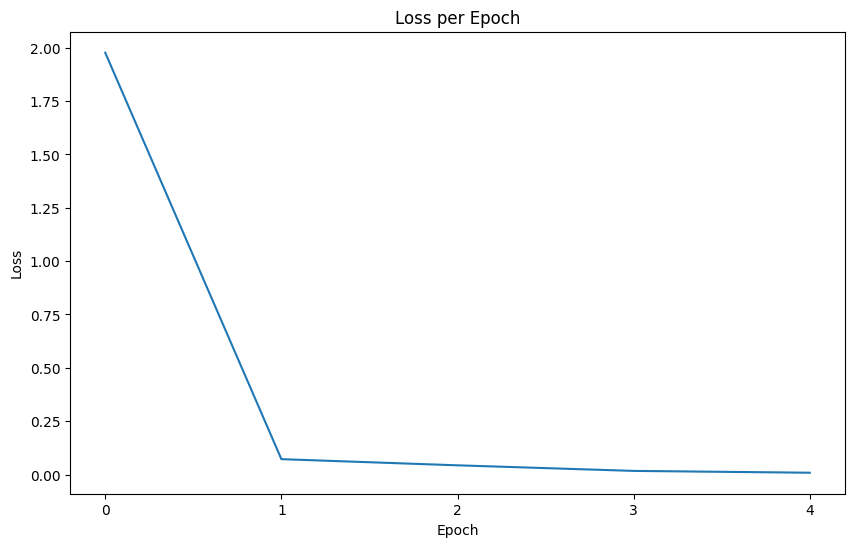

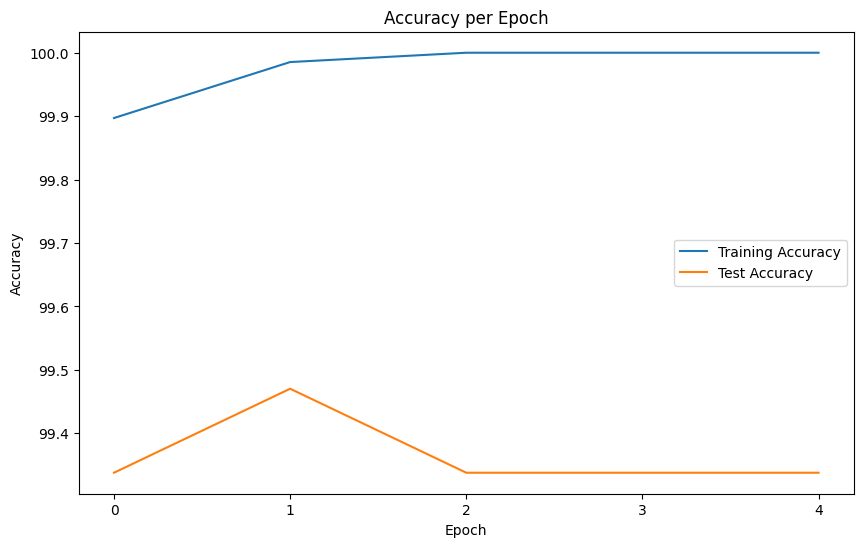

In [26]:
draw_charts(result)

# Conclusion
Fisrt of all, please note that for training all models, I have tried some different optimizers including SGD, Adam, Nadam, RMSprop and chose Adam for its superior convergence.

The four models trained in this notebook was exactly for the same task but each of them had some special characteristics. The 4-layer CNN despite being roughly big, could not reach very good result in comparison to ResNet34 based models. However it does not very bad in doing the task but took its time to converge. The version of this model with Batch Normalization and Dropout layers did slightly better on both training and validation sets

About three versions of ResNet34 based models, I trained all layers from scratch for the first one. It took more time to converge to a proper solution, however its accuracy was lower in comparison to the second and third models.

Second model, layer to train was the only additional fully connected layer on top of the base ResNet34 model. Therefore the training time got less time and reached fast convergence. However, the result was less favorable relative to the other versions. In the last one, the start was the optimal point of pretrained ResNet34, so it was a great point already. These weights were so proper that the Adam optimizer managed to find the global minimum of the loss function where the train accuracy touched 100% (with other optimizers the results was signifcant but in my experiments, this one was the best one). In the first glance it seems overfitting but the generalization gap between train and validation sets are less than 1% which shows us that this is actually not overfitting (There is a weak posibility that model overfitted on both train and validation sets but one could easily evalulate model on totally new dataset).

Generally, there is no signficant evidence in favor of overfitting in any model. All accuracies increases in both training and validation. Therefore, all of above model should generalize good enough for the given binary classfication task.

In conclusion, these models showed that fine-tuning was more desirable for this binary classification task because with less time and memory one could reach better results in comparison to design and/or train models from scratch. However, this is not a general fact, but only applicable to cases that two given tasks are similar to some degree.
